In [36]:
using JuMP, Gurobi, Ipopt,AmplNLWriter, NLopt
using Mosek, Cbc

In [65]:
k = 3              # number of waypoints
T = zeros(Int,k)   # vector of timepoints
xw = zeros(2,k)    # vector of waypoint locations

T[1] = 1
T[2] = 20
T[3] = 50

# define waypoints
xw = [ 1   4   6
       1   3   0]

L = .2 # length of car
;

In [93]:
m = Model(solver=AmplNLSolver("bonmin"))

@variable(m, x[1:2,1:T[k]])  # Inertial frame
@variable(m, θ[1:T[k]])      # Inertial frame orientation
@variable(m, -π/10 <= ϕ[1:T[k]] <= π/10)      # steering angle

@variable(m, vx[1:2,1:T[k]]) # velocity in inertial frame
@variable(m, v[1:T[k]])      # wheel velocity in body frame
@variable(m, vθ[1:T[k]])     # Orientation change velocity
@variable(m, -π/20 <= vϕ[1:T[k]] <= π/20)     # Orientation change velocity

@variable(m, u[1:T[k]] >= 0 )      # thruster input

# satisfy the dynamics (with zero initial velocity)
@constraint(m, vx[:,1] .== [0;0])
@constraint(m, v[1] == 0)
@constraint(m, u[1] == 0)
@constraint(m, ϕ[1] == 0)
@constraint(m, vϕ[1] == 0)
@constraint(m, θ[1] == π/2)

for t in 1:T[k]-1
    @constraint(m, x[:,t+1] .== x[:,t] + vx[:,t])
    @constraint(m, θ[t+1] == θ[t] + vθ[t])
    @constraint(m, ϕ[t+1] == ϕ[t] + vϕ[t])
    @constraint(m, v[t+1] == v[t] + u[t])
    
    @NLconstraint(m, vx[1,t] == v[t]*cos(θ[t]))
    @NLconstraint(m, vx[2,t] == v[t]*sin(θ[t]))
    @NLconstraint(m, vθ[t] == (v[t]/L)*tan(ϕ[t]))
end

#for t in 1:T[k]-1 
#    @expression(m, distanceTravelled, )
#end

# hit all waypoints
for i in [1 k]
    @constraint(m, x[:,T[i]] .== xw[:,i])
end

# minimize 2-norm (THIS IS LEAST-SQUARES)
λ = 100
@objective(m, Min, sum(v) + 
    λ*sum( (x[:,T[2:k]]-xw[:,2:k]).^2  ))
    #+ sum(sum((x[:,t+1] - x[:,t]).^2) for t in 1:T[k]-1))

solve(m)

Bonmin 1.8.4 using Cbc 2.9.7 and Ipopt 3.12.4
bonmin: 
Cbc3007W No integer variables - nothing to do

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 10.802877      450 1.937403
Cbc3007W No integer variables - nothing to do

 	"Finished"


:Optimal

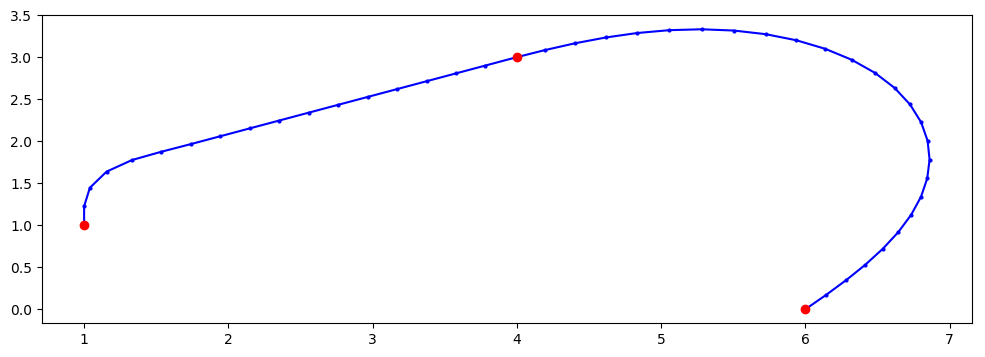

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3250fdad0>

In [94]:
using PyPlot
figure(figsize=(12,4))
xopt = getvalue(x)
plot( xopt[1,:][:], xopt[2,:][:], "b.-", markersize=4 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )

In [80]:
xopt = getvalue(x)

2×50 Array{Float64,2}:
 1.0  1.0  1.0  1.0      1.03974  1.15577  …   6.0          6.0        
 1.0  1.0  1.0  1.22462  1.44569  1.63802     -7.26472e-17  1.50375e-26

In [81]:
θopt = getvalue(θ)'

1×50 Array{Float64,2}:
 1.5708  1.5708  1.5708  1.39292  1.028  …  -2.28724  -2.28724  -2.28724

In [82]:
ϕopt = getvalue(ϕ)'

1×50 Array{Float64,2}:
 -2.90125e-20  -8.70374e-20  -0.15708  -0.314159  …  -0.00267903  -0.00214321

In [83]:
uopt = getvalue(u)'

1×50 Array{Float64,2}:
 1.04836e-25  0.224617  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  124.93

In [84]:
vopt = getvalue(v)'

1×50 Array{Float64,2}:
 1.05466e-25  3.15391e-25  0.224617  …  0.224617  0.224617  0.224617

In [85]:
vxopt = getvalue(vx)

2×50 Array{Float64,2}:
 1.85656e-25  3.70818e-25  1.37538e-17  …  5.65618e-17  6.32804e-17  0.0
 1.07957e-25  4.26087e-25  0.224617        6.49341e-17  7.26472e-17  0.0

In [86]:
vϕopt = getvalue(vϕ)'

1×50 Array{Float64,2}:
 -2.90125e-20  -0.15708  -0.15708  …  0.00120556  0.000535822  0.0